## SEIR Model

Based on http://gabgoh.github.io/COVID/index.html, with modifications

In [27]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from pandas.testing import assert_series_equal
from seir import Seir

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# Calibration: Alternating regimes of exposure and social distancing (see r_0_values)

# Note:
# - Hospitalisation rate is assumed to be p_severe + p_fatal = 20%
# - We might need to modify the model further to differentiate between hospitalised
# cases (here 20%) and the much smaller subset of ICU cases. A quick hack could be
# to just multiply 'I_severe_hospital' by a conditional ICU fraction we find in the
# literature, to then add all of 'I_fatal_hospital', and to call this time series ICUs
r0_steps = [
    ("2020-02-28", 3.5),
    ("2020-03-20", 1.25),
    ("2020-04-20", 2.5),
    ("2020-06-30", 3.5),
    ("2020-09-30", 3.5),
]

parameters = {
    "r_0_days": [21, 42, 63, 100],  # note: the last entry has to equal 'periods'
    "r_0_values": [3.5, 1.25, 2.5, 1.25],
    "t_infectious": 2.9,
    "t_incubation": 5.2,
    "p_severe": 0.18,
    "p_fatal": 0.02,
    "t_recovery_mild": 15 - 2.9,
    "t_recovery_severe": 31.5 - 2.9,
    "t_hospital_lag": 5,
    "t_death": 32 - 2.9,
    "icu_fraction": 0.5,  # share of severe hospital cases that needs ICU
}

N = 10000
start = {
    "S": 1.0 - 1 / N,
    "E": 1.0 / N,
    "I": 0.0,
    "I_mild": 0.0,
    "I_severe_home": 0.0,
    "I_severe_hospital": 0.0,
    "I_fatal_home": 0.0,
    "I_fatal_hospital": 0.0,
    "R_from_mild": 0.0,
    "R_from_severe": 0.0,
    "Dead": 0,
}

In [29]:
seir = Seir(params=parameters, start=start)
seir.simulate(r0_steps)

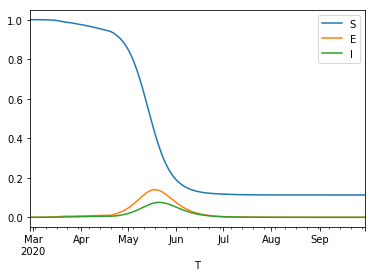

In [32]:
seir.data[["S", "E", "I"]].plot()

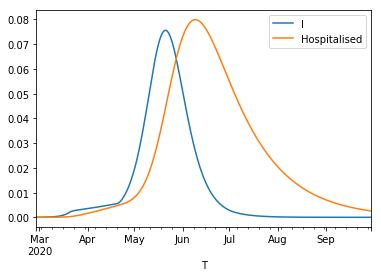

In [33]:
seir.data[["I", "Hospitalised"]].plot()

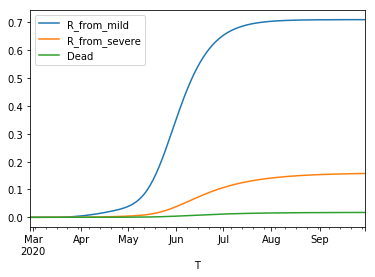

In [34]:
seir.data[["R_from_mild", "R_from_severe", "Dead"]].plot()